In [1]:
# importing libraries
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
import nltk
from nltk.stem.snowball import SnowballStemmer
import regex as re
from nltk.tokenize import sent_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
# download some packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\donfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\donfa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\donfa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# datasets
df_fake = pd.read_csv("News _dataset/Fake.csv")
df_true = pd.read_csv("News _dataset/True.csv")

In [4]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
# label them seperately
df_true['status'] = 0
df_fake['status'] = 1

In [7]:
# merge and remove unnecessary columns
df = pd.concat([df_true, df_fake])
df.drop(['subject', 'text', 'date'], axis=1, inplace=True)

* Since we are going to build model only based on the title feature, hence dropped text, date , subject

In [8]:
# let's blend the smoothie
random_indexes = np.random.randint(0, len(df), len(df))
df = df.iloc[random_indexes].reset_index(drop=True)

## Text analysis

In [9]:
pd.set_option('display.max_colwidth', 500)
random = np.random.randint(0, len(df), 20)
df.iloc[random]

,title,status
17003,Islamic State guerrilla attacks point to its future strategy,0
2996,DESPERATION OR STUPIDITY? GERMAN State Recruits REFUGEES With No Passports For Police Officer Jobs,1
36325,Vietnam braces for typhoon Khanun after floods kill 72,0
41213,Trump’s National Security Adviser Thinks Obama Was Right About Terrorism All Along,1
32086,Republican senator Graham says Trump's race remarks dividing U.S.,0
9106,Trump Promises To Destroy The USA During Interview With Lester Holt (VIDEO),1
37468,"FULL INTERVIEW: PRESIDENT TRUMP Nails It On Immigration, Obamacare, US Military, Jobs And “Incompetent” Nancy Pelosi [Video]",1
23698,"Holiday cheer boosts Amazon, Macy's and other retail stocks",0
41866,Ranks of world's refugees swell as asylum space shrinks: U.N.,0
15074,WATCH: HISPANIC MAN WHO USED To “Beat up Trump supporters” Gets Choked Up In Passionate Speech About How LYING Media Turned Him Into A Trump Supporter,1


* work needs to be done on data before feeding to neural network-
1. Remove punctuations eg ""
2. Convert uppercase to lowercase
3. No need to apply stemming, otherwise it will just shorten the word unnecessary
4. Apply lemmatization
5. Remove all the stopwords
6. Finally make vocabulary after completion of 5 steps

In [10]:
# Null values
df.isnull().sum()

title     0
status    0
dtype: int64

In [11]:
# longest sentence length
def longest_sentence_length(text):
    return len(text.split())


df['maximum_length'] = df['title'].apply(lambda x: longest_sentence_length(x))
print('longest sentence having length -')
max_length = max(df['maximum_length'].values)
print(max_length)

longest sentence having length -
42


In [12]:
# Text cleaning
text_cleaning = "\b0\S*|\b[^A-Za-z0-9]+"


def preprocess_filter(text, stem=False):
    text = re.sub(text_cleaning, " ", str(text.lower()).strip())
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                stemmer = SnowballStemmer(language='english')
                token = stemmer.stem(token)
            tokens.append(token)
    return " ".join(tokens)

* The regular expression pattern removes non-alphanumeric characters and digits, enhancing text cleanliness for subsequent analysis.
* Text preprocessing function standardizes text by converting it to lowercase, removing stop words, and optionally applying stemming, facilitating effective natural language processing.
* Stemming simplifies words to their root forms, aiding in capturing underlying semantic meanings and improving search accuracy.
* Removal of stop words reduces noise in text data, focusing on informative words and enhancing the quality of subsequent analysis.

In [13]:
# Word embedding with pre padding
def one_hot_encoded(text, vocab_size=5000, max_length=40):
    hot_encoded = one_hot(text, vocab_size)
    return hot_encoded

In [14]:
# word embedding pipeline
def word_embedding(text):
    preprocessed_text = preprocess_filter(text)
    return one_hot_encoded(preprocessed_text)

In [15]:
# Creating NN Model
embedded_features = 40
model = Sequential()
model.add(Embedding(5000, embedded_features, input_length=max_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 42, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256501 (1001.96 KB)
Trainable params: 256501 (1001.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


* The model utilizes a vocabulary size of 5000, reflecting the extensive nature of the dataset and the need to handle a wide range of words effectively.
* By embedding input tokens into 40-dimensional vectors, the model captures nuanced semantic relationships, crucial for understanding the complex language patterns present in the dataset.
* Leveraging an LSTM layer with 100 units, the model effectively learns from the extensive sequential data, ensuring it captures long-term dependencies and context effectively.
* With a final dense layer employing a sigmoid activation function, the model delivers binary classification predictions, adeptly classifying the vast and varied dataset with accuracy.

In [16]:
# One hot encoded title
one_hot_encoded_title = df['title'].apply(lambda x: word_embedding(x)).values

In [17]:
# padding to make the size equal of the sequences
padded_encoded_title = pad_sequences(
    one_hot_encoded_title, maxlen=max_length, padding='pre')

In [18]:
# Splitting
X = padded_encoded_title
y = df['status'].values
y = np.array(y)

# shapes
print(X.shape)
print(y.shape)

(44898, 42)
(44898,)


In [19]:
# shape and size
print('X shape {}'.format(X.shape))
print('y shape {}'.format(y.shape))

X shape (44898, 42)
y shape (44898,)


In [20]:
# Splitting into training, testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Shape and size of train and test dataset
print('X train shape {}'.format(X_train.shape))
print('X test shape {}'.format(X_test.shape))
print('y train shape {}'.format(y_train.shape))
print('y test shape {}'.format(y_test.shape))

X train shape (33673, 42)
X test shape (11225, 42)
y train shape (33673,)
y test shape (11225,)


In [21]:
# Model training
# training
history= model.fit(X_train, y_train, validation_data=(
    X_test, y_test), epochs=15, batch_size=64)

Epoch 1/15


527/527 [==============================] - 25s 42ms/step - loss: 0.2068 - accuracy: 0.9174 - val_loss: 0.1137 - val_accuracy: 0.9558
Epoch 2/15
527/527 [==============================] - 21s 40ms/step - loss: 0.0790 - accuracy: 0.9721 - val_loss: 0.0948 - val_accuracy: 0.9661
Epoch 3/15
527/527 [==============================] - 21s 41ms/step - loss: 0.0435 - accuracy: 0.9855 - val_loss: 0.0989 - val_accuracy: 0.9692
Epoch 4/15
527/527 [==============================] - 24s 46ms/step - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.1091 - val_accuracy: 0.9702
Epoch 5/15
527/527 [==============================] - 24s 45ms/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.1574 - val_accuracy: 0.9677
Epoch 6/15
527/527 [==============================] - 22s 42ms/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.1486 - val_accuracy: 0.9702
Epoch 7/15
527/527 [==============================] - 26s 49ms/step - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.1691 - val_accurac

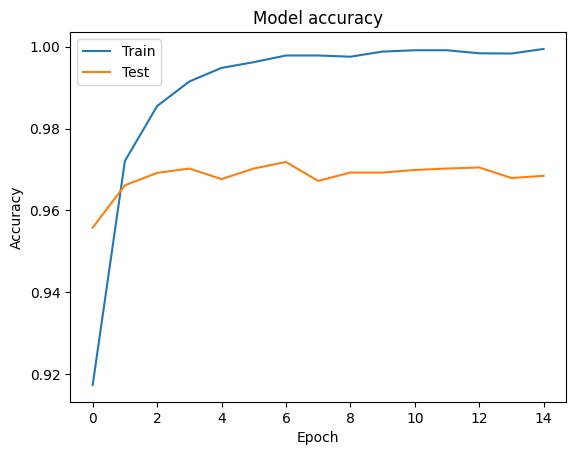

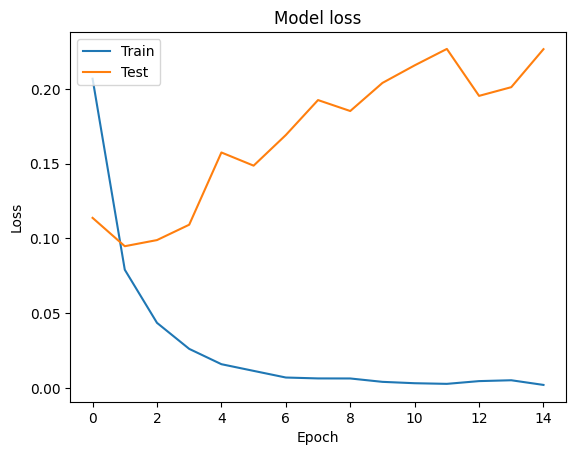

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluation

In [23]:
# setting threshold value
def best_threshold_value(thresholds: list, X_test):
    accuracies = []
    for thresh in thresholds:
        ypred = model.predict(X_test)
        ypred = np.where(ypred > thresh, 1, 0)
        accuracies.append(accuracy_score(y_test, ypred))
    return pd.DataFrame({
        'Threshold': thresholds,
        'Accuracy': accuracies
    })

In [24]:
best_threshold_value([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], X_test)

351/351 [==============================] - 4s 11ms/step


,Threshold,Accuracy
0,0.4,0.968820
1,0.5,0.968463
2,0.6,0.968998
3,0.7,0.969443
4,0.8,0.969621
5,0.9,0.969443


* Not much difference in accuray 
* But the most suitable threshold value we have got is **0.4**

In [25]:
# Predictino value at threshold 0.4
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.4, 1, 0)

351/351 [==============================] - 4s 10ms/step


In [26]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_pred, y_test))
print('----------------')
print('Classification report')
print(classification_report(y_pred, y_test))

Confusion matrix
[[5134  145]
 [ 205 5741]]
----------------
Classification report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5279
           1       0.98      0.97      0.97      5946

    accuracy                           0.97     11225
   macro avg       0.97      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225



In [27]:
model.save("lstmmo.h5")

* The model performs well in both classes, with high precision, recall, and F1-score, suggesting robustness in classification.
* There is no significant imbalance in performance between the two classes, as evidenced by similar metrics for both classes.
* The model's overall performance is excellent, achieving high accuracy on the dataset.

## Predictions

In [28]:
# input generator
def prediction_input_processing(text):
    encoded = word_embedding(text)
    padded_encoded_title = pad_sequences(
        [encoded], maxlen=max_length, padding='pre')
    output = model.predict(padded_encoded_title)
    output = np.where(0.4 > output, 1, 0)
    if output[0][0] == 1:
        return 'Yes this News is fake'
    return 'No, It is not fake'

In [29]:
# predictions
prediction_input_processing(
    'Americans are more concerned over Indians fake open source contribution')

1/1 [==============================] - 0s 40ms/step


'Yes this News is fake'

In [30]:
news = 'Trump Just Sent Michelle Obama a Bill She will Never Be able to pay in her lifetime'
prediction_input_processing(news)

1/1 [==============================] - 0s 33ms/step


'No, It is not fake'

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['title'])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['status'], test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_train = rf_classifier.predict(X_train)
y_pred_test = rf_classifier.predict(X_test)

# Evaluate the model
print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17110
           1       1.00      1.00      1.00     18808

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4270
           1       0.98      0.98      0.98      4710

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [32]:
from sklearn.tree import DecisionTreeClassifier

# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['title'])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['status'], test_size=0.2, random_state=42)

# Initialize and train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predictions
y_pred_train = dt_classifier.predict(X_train)
y_pred_test = dt_classifier.predict(X_test)

# Evaluate the model
print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17110
           1       1.00      1.00      1.00     18808

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4270
           1       0.96      0.97      0.96      4710

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [33]:
from sklearn.linear_model import LogisticRegression

# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['title'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['status'], test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier.fit(X_train, y_train)

# Predictions
y_pred_train = lr_classifier.predict(X_train)
y_pred_test = lr_classifier.predict(X_test)

# Evaluate the model
print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     17110
           1       0.98      0.97      0.97     18808

    accuracy                           0.97     35918
   macro avg       0.97      0.97      0.97     35918
weighted avg       0.97      0.97      0.97     35918

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4270
           1       0.97      0.96      0.96      4710

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [34]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Assuming max_length and embedded_features are defined
max_length = 40
embedded_features = 40

# Text cleaning regex pattern
text_cleaning = r'\b0\S*|\b[^A-Za-z0-9]+'

# Function for text preprocessing


def preprocess_filter(text):
    text = re.sub(text_cleaning, " ", str(text).lower().strip())
    return text

# Function for one-hot encoding


def one_hot_encoded(text, vocab_size=5000):
    hot_encoded = one_hot(text, vocab_size)
    return hot_encoded

# Function for word embedding


def word_embedding(text):
    preprocessed_text = preprocess_filter(text)
    hot_encoded = one_hot_encoded(preprocessed_text)
    return hot_encoded


# Creating CNN model
model = Sequential()
model.add(Embedding(5000, embedded_features, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Assuming df is the DataFrame containing your data
# One hot encoded title
one_hot_encoded_title = df['title'].apply(lambda x: word_embedding(x)).values

# Padding sequences
padded_encoded_title = pad_sequences(
    one_hot_encoded_title, maxlen=max_length, padding='pre')

# Splitting data
X = padded_encoded_title
y = df['status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Model training
history = model.fit(X_train, y_train, validation_data=(
    X_test, y_test), epochs=15, batch_size=64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 40)            200000    
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           25728     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 225857 (882.25 KB)
Trainable params: 225857 (882.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/15
527/527 [==============================] - 6s 10ms/step - loss: 

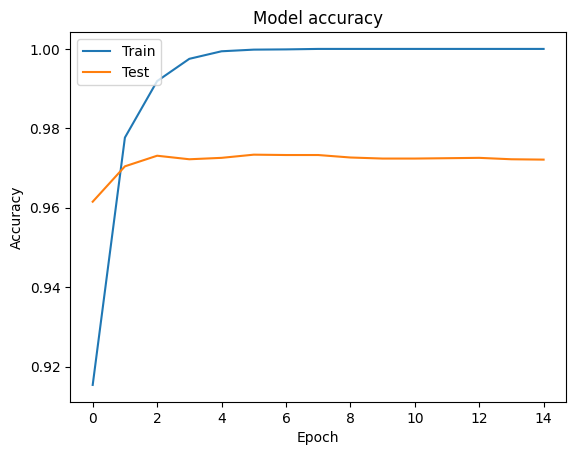

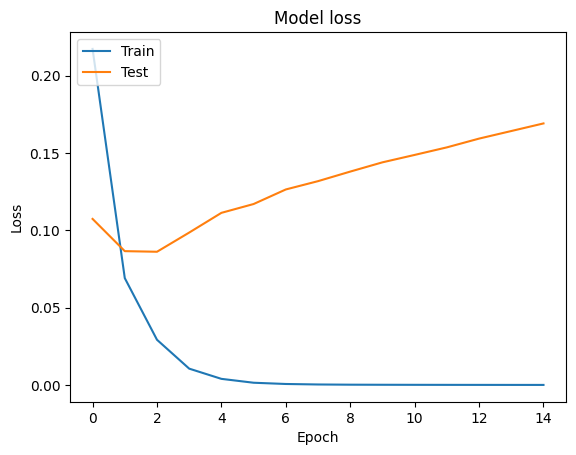

In [35]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.4, 1, 0)

351/351 [==============================] - 1s 1ms/step


In [36]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_pred, y_test))
print('----------------')
print('Classification report')
print(classification_report(y_pred, y_test))

Confusion matrix
[[5193  125]
 [ 183 5724]]
----------------
Classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5318
           1       0.98      0.97      0.97      5907

    accuracy                           0.97     11225
   macro avg       0.97      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225



In [37]:
model.save("cnnmodel.h5")

In [38]:
# Function to predict input
def prediction_input_processing(text):
    encoded = word_embedding(text)
    padded_encoded_title = pad_sequences(
        [encoded], maxlen=max_length, padding='pre')
    output = model.predict(padded_encoded_title)
    output = np.where(output > 0.4, 1, 0)  # Adjust threshold as needed
    if output[0][0] == 1:
        return 'Yes, this news is fake'
    return 'No, it is not fake'


# Testing prediction
print(prediction_input_processing(
    'Americans are more concerned over Indians fake open source contribution'))

1/1 [==============================] - 0s 25ms/step
No, it is not fake


In [39]:
# predictions
prediction_input_processing(
    'Americans are more concerned over Indians fake open source contribution')

1/1 [==============================] - 0s 21ms/step


'No, it is not fake'

In [44]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the trained model
model = load_model("cnnmodel.h5")
# input generator


def prediction_input_processing(text):
    encoded = word_embedding(text)
    padded_encoded_title = pad_sequences(
        [encoded], maxlen=max_length, padding='pre')
    output = model.predict(padded_encoded_title)
    output = np.where(0.4 > output, 1, 0)
    if output[0][0] == 1:
        return 'Yes this News is fake'
    return 'No, It is not fake'


# Testing prediction
print(prediction_input_processing(
    'Americans are more concerned over Indians fake open source contribution'))

1/1 [==============================] - 0s 54ms/step
Yes this News is fake
